# Adversarial Training with `mister_ed`
This file will contain the basics on how to perform adversarial training under the `mister_ed` framework. It's highly recommended that you have walked through tutorial_1 before going through this.

As usual, we'll start by importing everything we'll need

In [1]:
# EXTERNAL LIBRARY IMPORTS
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 

import torch # Need torch version >=0.3
import torch.nn as nn 
import torch.optim as optim 
assert float(torch.__version__[:3]) >= 0.3


In [2]:
# MISTER ED SPECIFIC IMPORT BLOCK
# (here we do things so relative imports work )
# Universal import block 
# Block to get the relative imports working 
import os
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import config
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap 
import adversarial_attacks as aa
import spatial_transformers as st


Now let's define what we want to do here:

Our goal is to run through a few training epochs of a pretrained classifier where we augment the training data with a set of adversarial examples. For simplicity's sake, let's just try and train a few epochs of a 20-layer ResNet trained on CIFAR-10, defended against an FGSM attack of $\epsilon=8$.

First things first, let's instatiate our pretrained classifier and our training dataset. 

In [3]:
cifar_trainset = cifar_loader.load_cifar_data('train')
model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=20, return_normalizer=True)

Files already downloaded and verified


And now let's build the attack parameters: an object that contains all the information to perform an attack on a minibatch. So first let's build an attack object and then furnish it with the necessary kwargs. 

Like in tutorial 1, to create an attack object, we'll need to create a threat model and a loss function

In [5]:
delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                              {'lp_style': 'inf', 
                               'lp_bound': 8.0 / 255})
attack_loss = plf.VanillaXentropy(model, normalizer)
attack_object = aa.FGSM(model, normalizer, delta_threat, attack_loss)


And then we build the `AttackParameters` object, which just wraps the attack object with the kwargs needed to call the `attack(...)` method on attack. For FGSM attacks, we just want to turn the verbosity off, but for more complicated attacks, this will be more involved. Typically in training, we generate a single adversarial example per training point, but to be speedy here, let's only create 1 example per every 5 training points.


In [6]:
attack_kwargs = {'verbose': False} # kwargs to be called in attack_object.attack(...)
attack_params = advtrain.AdversarialAttackParameters(attack_object, proportion_attacked=0.2, 
                                                     attack_specific_params={'attack_kwargs': attack_kwargs})


With our attack parameters built, we can build the object that handles training for us: this is instatiated with knowledge of the classifier, normalizer and some identifying features such as the *name* of the experiment and architecture. It's worthwhile to be informative with these so you keep which attacks this model is trained against straight.

In [7]:
experiment_name = 'tutorial_fgsm'
architecture = 'resnet20'
training_obj = advtrain.AdversarialTraining(model, normalizer, experiment_name, architecture)

When you start training though, you'll need to furnish the trainer with some extra arguments:
    - the data loader 
    - the number of epochs to train for 
    - a loss function (not one of the `mister_ed` custom loss functions though!)
    - which optimizer to use (defaults to Adam with decent hyperparams)
    - the attack parameters object 
    - whether or not to use the gpu (defaults to not using GPU)
    - the verbosity level (ranging from ['low', 'medium', 'high', 'snoop'] (defaults to 'medium')
    - whether or not to save the generated adversarial examples as images (defaults to false)
    
To be cute, we'll just train for two epochs so you get the picture. Also note that unless the verbosity is set to `low`, a checkpoint will be saved after every epoch. By default, these checkpoints are named like `<experiment_name>.<architecture_name>.<epoch>.path.tar`


In [8]:
train_loss = nn.CrossEntropyLoss() # just use standard XEntropy to train
training_logger = training_obj.train(cifar_trainset, 2, train_loss, 
                                     attack_parameters=attack_params, 
                                     verbosity='snoop', loglevel='snoop') 

[1,     1] accuracy: (4.000, 100.000)
[1,     1] loss: 1.599944
[1,     2] accuracy: (20.000, 100.000)
[1,     2] loss: 1.240227
[1,     3] accuracy: (16.000, 100.000)
[1,     3] loss: 1.249226
[1,     4] accuracy: (12.000, 96.000)
[1,     4] loss: 1.179514
[1,     5] accuracy: (12.000, 96.000)
[1,     5] loss: 1.209120
[1,     6] accuracy: (28.000, 100.000)
[1,     6] loss: 0.802554
[1,     7] accuracy: (20.000, 100.000)
[1,     7] loss: 0.747037
[1,     8] accuracy: (8.000, 96.000)
[1,     8] loss: 1.002974
[1,     9] accuracy: (28.000, 100.000)
[1,     9] loss: 0.521626
[1,    10] accuracy: (20.000, 100.000)
[1,    10] loss: 0.576680
[1,    11] accuracy: (28.000, 96.000)
[1,    11] loss: 0.480392
[1,    12] accuracy: (24.000, 96.000)
[1,    12] loss: 0.451429
[1,    13] accuracy: (28.000, 92.000)
[1,    13] loss: 0.432828
[1,    14] accuracy: (20.000, 92.000)
[1,    14] loss: 0.476083
[1,    15] accuracy: (12.000, 96.000)
[1,    15] loss: 0.530713
[1,    16] accuracy: (28.000, 84.00

[1,   128] loss: 0.420743
[1,   129] accuracy: (40.000, 100.000)
[1,   129] loss: 0.327217
[1,   130] accuracy: (24.000, 100.000)
[1,   130] loss: 0.368050
[1,   131] accuracy: (36.000, 96.000)
[1,   131] loss: 0.394432
[1,   132] accuracy: (32.000, 100.000)
[1,   132] loss: 0.390075
[1,   133] accuracy: (28.000, 96.000)
[1,   133] loss: 0.405405
[1,   134] accuracy: (40.000, 100.000)
[1,   134] loss: 0.387147
[1,   135] accuracy: (32.000, 100.000)
[1,   135] loss: 0.307586
[1,   136] accuracy: (16.000, 96.000)
[1,   136] loss: 0.470789
[1,   137] accuracy: (20.000, 96.000)
[1,   137] loss: 0.404960
[1,   138] accuracy: (20.000, 100.000)
[1,   138] loss: 0.392479
[1,   139] accuracy: (56.000, 96.000)
[1,   139] loss: 0.355760
[1,   140] accuracy: (24.000, 100.000)
[1,   140] loss: 0.429897
[1,   141] accuracy: (36.000, 96.000)
[1,   141] loss: 0.506881
[1,   142] accuracy: (20.000, 100.000)
[1,   142] loss: 0.345809
[1,   143] accuracy: (40.000, 96.000)
[1,   143] loss: 0.324644
[1,   

[1,   256] accuracy: (36.000, 96.000)
[1,   256] loss: 0.456183
[1,   257] accuracy: (36.000, 92.000)
[1,   257] loss: 0.368351
[1,   258] accuracy: (44.000, 96.000)
[1,   258] loss: 0.277809
[1,   259] accuracy: (48.000, 96.000)
[1,   259] loss: 0.369027
[1,   260] accuracy: (28.000, 96.000)
[1,   260] loss: 0.399493
[1,   261] accuracy: (40.000, 96.000)
[1,   261] loss: 0.402053
[1,   262] accuracy: (52.000, 100.000)
[1,   262] loss: 0.350295
[1,   263] accuracy: (36.000, 92.000)
[1,   263] loss: 0.301674
[1,   264] accuracy: (20.000, 100.000)
[1,   264] loss: 0.412036
[1,   265] accuracy: (40.000, 100.000)
[1,   265] loss: 0.336813
[1,   266] accuracy: (28.000, 100.000)
[1,   266] loss: 0.384384
[1,   267] accuracy: (40.000, 100.000)
[1,   267] loss: 0.338615
[1,   268] accuracy: (36.000, 96.000)
[1,   268] loss: 0.359784
[1,   269] accuracy: (40.000, 88.000)
[1,   269] loss: 0.374760
[1,   270] accuracy: (32.000, 92.000)
[1,   270] loss: 0.366776
[1,   271] accuracy: (32.000, 100.0

[1,   383] loss: 0.358840
[1,   384] accuracy: (40.000, 96.000)
[1,   384] loss: 0.342919
[1,   385] accuracy: (40.000, 92.000)
[1,   385] loss: 0.336729
[1,   386] accuracy: (40.000, 100.000)
[1,   386] loss: 0.353301
[1,   387] accuracy: (44.000, 96.000)
[1,   387] loss: 0.325844
[1,   388] accuracy: (12.000, 96.000)
[1,   388] loss: 0.387046
[1,   389] accuracy: (60.000, 100.000)
[1,   389] loss: 0.340109
[1,   390] accuracy: (44.000, 96.000)
[1,   390] loss: 0.325224
[1,   391] accuracy: (25.000, 93.750)
[1,   391] loss: 0.414688
COMPLETED EPOCH 0001... checkpointing here
[2,     1] accuracy: (44.000, 96.000)
[2,     1] loss: 0.357591
[2,     2] accuracy: (56.000, 96.000)
[2,     2] loss: 0.383988
[2,     3] accuracy: (48.000, 100.000)
[2,     3] loss: 0.240366
[2,     4] accuracy: (24.000, 88.000)
[2,     4] loss: 0.376790
[2,     5] accuracy: (28.000, 100.000)
[2,     5] loss: 0.379570
[2,     6] accuracy: (48.000, 96.000)
[2,     6] loss: 0.380804
[2,     7] accuracy: (36.000, 9

[2,   119] loss: 0.301239
[2,   120] accuracy: (60.000, 100.000)
[2,   120] loss: 0.307872
[2,   121] accuracy: (48.000, 96.000)
[2,   121] loss: 0.299466
[2,   122] accuracy: (48.000, 92.000)
[2,   122] loss: 0.409709
[2,   123] accuracy: (28.000, 100.000)
[2,   123] loss: 0.341992
[2,   124] accuracy: (72.000, 100.000)
[2,   124] loss: 0.287945
[2,   125] accuracy: (32.000, 96.000)
[2,   125] loss: 0.356749
[2,   126] accuracy: (56.000, 96.000)
[2,   126] loss: 0.269052
[2,   127] accuracy: (32.000, 100.000)
[2,   127] loss: 0.449142
[2,   128] accuracy: (56.000, 96.000)
[2,   128] loss: 0.300629
[2,   129] accuracy: (44.000, 96.000)
[2,   129] loss: 0.325262
[2,   130] accuracy: (40.000, 100.000)
[2,   130] loss: 0.351304
[2,   131] accuracy: (56.000, 96.000)
[2,   131] loss: 0.299945
[2,   132] accuracy: (52.000, 88.000)
[2,   132] loss: 0.416187
[2,   133] accuracy: (24.000, 96.000)
[2,   133] loss: 0.379433
[2,   134] accuracy: (40.000, 100.000)
[2,   134] loss: 0.281973
[2,   13

[2,   247] accuracy: (48.000, 100.000)
[2,   247] loss: 0.294170
[2,   248] accuracy: (44.000, 92.000)
[2,   248] loss: 0.413803
[2,   249] accuracy: (36.000, 96.000)
[2,   249] loss: 0.417565
[2,   250] accuracy: (52.000, 96.000)
[2,   250] loss: 0.315794
[2,   251] accuracy: (48.000, 92.000)
[2,   251] loss: 0.365734
[2,   252] accuracy: (44.000, 96.000)
[2,   252] loss: 0.358048
[2,   253] accuracy: (60.000, 100.000)
[2,   253] loss: 0.314237
[2,   254] accuracy: (52.000, 100.000)
[2,   254] loss: 0.332318
[2,   255] accuracy: (52.000, 92.000)
[2,   255] loss: 0.357087
[2,   256] accuracy: (44.000, 96.000)
[2,   256] loss: 0.332721
[2,   257] accuracy: (52.000, 92.000)
[2,   257] loss: 0.431098
[2,   258] accuracy: (36.000, 92.000)
[2,   258] loss: 0.361090
[2,   259] accuracy: (44.000, 96.000)
[2,   259] loss: 0.311500
[2,   260] accuracy: (40.000, 96.000)
[2,   260] loss: 0.386707
[2,   261] accuracy: (40.000, 92.000)
[2,   261] loss: 0.291294
[2,   262] accuracy: (24.000, 96.000)

[2,   374] loss: 0.282248
[2,   375] accuracy: (44.000, 96.000)
[2,   375] loss: 0.324487
[2,   376] accuracy: (48.000, 96.000)
[2,   376] loss: 0.311645
[2,   377] accuracy: (52.000, 96.000)
[2,   377] loss: 0.346868
[2,   378] accuracy: (48.000, 96.000)
[2,   378] loss: 0.340029
[2,   379] accuracy: (40.000, 96.000)
[2,   379] loss: 0.448244
[2,   380] accuracy: (28.000, 96.000)
[2,   380] loss: 0.379089
[2,   381] accuracy: (48.000, 100.000)
[2,   381] loss: 0.295918
[2,   382] accuracy: (40.000, 100.000)
[2,   382] loss: 0.377850
[2,   383] accuracy: (56.000, 92.000)
[2,   383] loss: 0.361118
[2,   384] accuracy: (52.000, 96.000)
[2,   384] loss: 0.357928
[2,   385] accuracy: (52.000, 92.000)
[2,   385] loss: 0.387262
[2,   386] accuracy: (48.000, 96.000)
[2,   386] loss: 0.366256
[2,   387] accuracy: (44.000, 100.000)
[2,   387] loss: 0.315021
[2,   388] accuracy: (28.000, 92.000)
[2,   388] loss: 0.518656
[2,   389] accuracy: (24.000, 92.000)
[2,   389] loss: 0.457699
[2,   390] 

The printouts look like:
``` 
[epoch_no, minibatch_no] accuracy: (X, Y) 
[epoch_no, minibatch_no] loss: Z
```

- X is the percent of successfully classified *adversarial* examples generated from that minibatch only
- Y is the percent of successfully classified *original* examples on that minibatch only
- Z is the value of the loss function after that minibatch

The output of training is a `TrainingLogger` class that stores essentially what was printed, and is separately controlled by its own `loglevel` argument. This can be accessed (and just to be safe, sorted using `sort_series`) and plotted as follows:

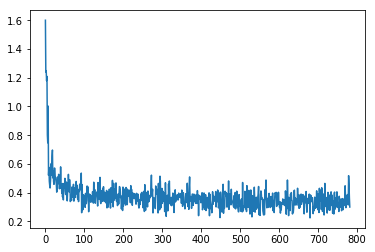

In [9]:
# Plot training loss
import matplotlib.pyplot as plt 
plt.plot(training_logger.sort_series('training_loss', return_keys=False))

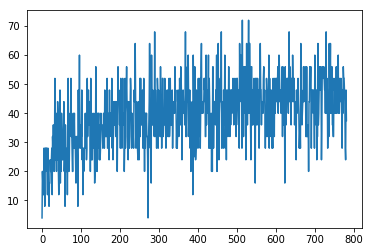

In [10]:
# Plot adversarial accuracy as we train 
# This should be noisy, but generally going UP
plt.plot([_[0] for _ in training_logger.sort_series('attack', return_keys=False)])

Once training completes, you can verify that the checkpoints are indeed stored in wherever you have set up pretrained models to be stored. By default this is `mister_ed/pretrained_models/`, so you should have a `tutorial_fgsm.resnet20.000002.path.tar` file

# Restarting from Checkpoint
When training, sometimes @#\$& happens and things break. This is why we checkpoint. Here we'll show how to restart from checkpoint in training:

Suppose we want to pick back up from where we left off with the experiment/architecture pair defined above `(tutorial_fgsm, resnet20)`. Then we want to do the following steps:

1. Instantiate a model of the same architecture (weights don't matter, since we'll load from the checkpoint) 
2. Build an `AdversarialTraining` object using this model, its normalizer, and the same experiment name, architecture name 
3. Build a loss function, attack_parameters object, and all other identical kwargs from the first (aborted) training run 
4. Run the training using the training object's `train_from_checkpoint` method instead of `train`. All the kwargs are the same 

In [11]:
naive_model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=20, return_normalizer=True)
new_train_obj = advtrain.AdversarialTraining(naive_model, normalizer, experiment_name, architecture)

delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                              {'lp_style': 'inf', 
                               'lp_bound': 8.0 / 255})
attack_loss = plf.VanillaXentropy(naive_model, normalizer)
attack_object = aa.FGSM(naive_model, normalizer, delta_threat, attack_loss)
attack_kwargs = {'verbose': False} # kwargs to be called in attack_object.attack(...)
attack_params = advtrain.AdversarialAttackParameters(attack_object, proportion_attacked=0.2, 
                                                     attack_specific_params={'attack_kwargs': attack_kwargs})

new_train_obj.train_from_checkpoint(cifar_trainset, 4, train_loss, attack_parameters=attack_params, 
                                    verbosity='high')

[3,   100] accuracy: (52.000, 100.000)
[3,   100] loss: 0.345297
[3,   200] accuracy: (44.000, 88.000)
[3,   200] loss: 0.326587
[3,   300] accuracy: (52.000, 92.000)
[3,   300] loss: 0.336156
COMPLETED EPOCH 0003... checkpointing here
[4,   100] accuracy: (64.000, 100.000)
[4,   100] loss: 0.312935
[4,   200] accuracy: (52.000, 84.000)
[4,   200] loss: 0.325036
[4,   300] accuracy: (44.000, 96.000)
[4,   300] loss: 0.333294
COMPLETED EPOCH 0004... checkpointing here
Finished Training


Once this finishes, notice that you should now have a file 
`tutorial_fgsm.resnet20.000004.path.tar` in your pretrained_models directory.

# Using the training script 
Using an ipython notebook isn't typically ideal for training, since it mandates you keep your browser window open. To this end, we've built a script to perform adversarial training in a tmux/screen background. This is located in `scripts/advtrain.py`. Here's what we've found are best practices for doing this:

- Copy `scripts/advtrain.py` into `scripts/advtrain_<DESCRIPTIVE_EXPERIMENT_NAME>.py`
- Modify the `build_attack_params` method in `scripts/advtrain_<DESCRIPTIVE_EXPERIMENT_NAME>.py` to use the attack parameters that you want. There's plenty of prebuilt attack parameters in that file to choose from. 
- In a tmux/screen, from `mister_ed`, run 

```python -m scripts.advtrain_DESCRIPTIVE_EXPERIMENT_NAME --exp <DESCRIPTIVE_EXPERIMENT_NAME> --arch <ARCHITECTURE_CHOICE> --verbosity [snoop/high/medium]```

- To resume, you can optionally add the `-r` or `--resume` flag to the script call


# A note on GPU Usage
If you have access to a GPU on your machine, you'll probably want to leverage its power when doing training and attacks. `mister_ed` has been designed so "standard" GPU behavior should be supported without any extra effort. By "standard" GPU behavior, I mean that all objects reside on the same device: either all on the GPU or none on the GPU. If there is a GPU on your machine, which one can check from the output of 
```
import torch.cuda as cuda 
print(cuda.is_available()) 
```
Globally, unless otherwise specified, all objects will be initialized in GPU-mode if this output is `True`. This is done behind-the-scenes by setting the environment variable `MISTER_ED_GPU`. If you have access to a GPU, but wouldn't like to use it, you can manually override this environment variable by calling:
```
import utils.pytorch_utils as utils 
utils.set_global_gpu(False)
```
And then none of your objects will be in GPU-mode by default. 

For nonstandard GPU behavior, you should initialize any object that differs from the default gpu status (as defined by `MISTER_ED_GPU`) with the kwarg `manual_gpu=<True/False>`
